The aim of this project is to make prices prediction for houses in India based on different numerical and cathegorical values. First step is to import all the nesessary libraries and take a brief look on data. 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib 
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder

df = pd.read_csv(r'C:\Users\Polya\OneDrive\Рабочий стол\BA tests\Bangalore.csv')
print(df.head())
df.describe()
df.shape

      Price  Area                         Location  No. of Bedrooms  Resale  \
0  30000000  3340                 JP Nagar Phase 1                4       0   
1   7888000  1045       Dasarahalli on Tumkur Road                2       0   
2   4866000  1179  Kannur on Thanisandra Main Road                2       0   
3   8358000  1675                     Doddanekundi                3       0   
4   6845000  1670                          Kengeri                3       0   

   MaintenanceStaff  Gymnasium  SwimmingPool  LandscapedGardens  JoggingTrack  \
0                 1          1             1                  1             1   
1                 0          1             1                  1             1   
2                 0          1             1                  1             1   
3                 0          0             0                  0             0   
4                 1          1             1                  1             1   

   ...  LiftAvailable  BED  VaastuComp

(6207, 40)


Our goal is to predict SalePrice, we need to check whether it more or less distributes normally. If not, a transformation is needed. The regressors work best on normal distributions.

As we see, the target variable Sale Price is not normally distributed. This can reduce the performance of the ML regression models because some ML assumes normal distribution. Therefore we make a log transformation, the resulting distrbution looks much better.

In [2]:
shape = df.shape
print(shape)

processed_data = df

(6207, 40)


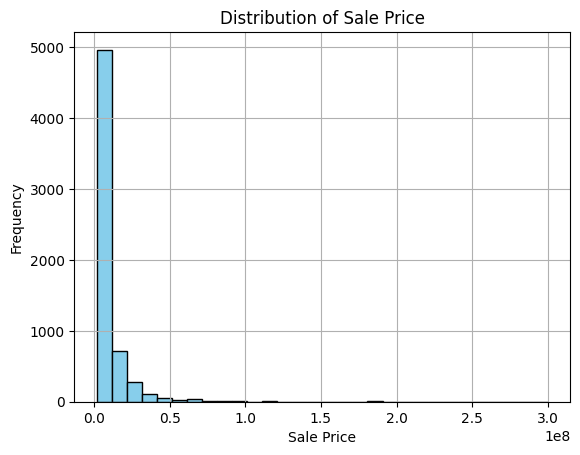

Skewness: 8.466559349404907
Kurtosis: 111.72178468902132


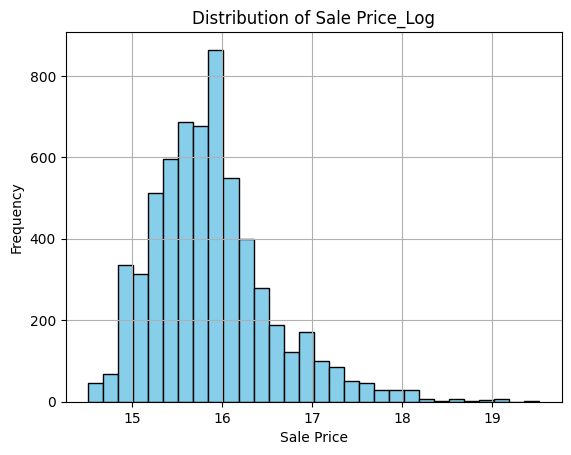

Skewness: 8.466559349404907
Kurtosis: 111.72178468902132


In [3]:
plt.hist(processed_data['Price'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate skewness and kurtosis
skewness = processed_data['Price'].skew()
kurtosis = processed_data['Price'].kurt()

print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

processed_data['SalePrice_Log'] = np.log(processed_data['Price'])

plt.hist(processed_data['SalePrice_Log'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Sale Price_Log')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Calculate skewness and kurtosis
skewness_log = processed_data['SalePrice_Log'].skew()
kurtosis_log = processed_data['SalePrice_Log'].kurt()

print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

From now on we will use transformed data as a target feature. Also we divide other features into numerical and cathegorical. 


In [4]:
target = "SalePrice_Log"
y_train = processed_data[target]

numerical_feats = processed_data.dtypes[processed_data.dtypes != "object"].index
categorical_feats = processed_data.dtypes[processed_data.dtypes == "object"].index


Lets calculate correlations only for numeric columns. After plotting result we define our threshold for minimum correlation value. We will drop columns with low correlation in order to make our prediction more straight forwarded. 

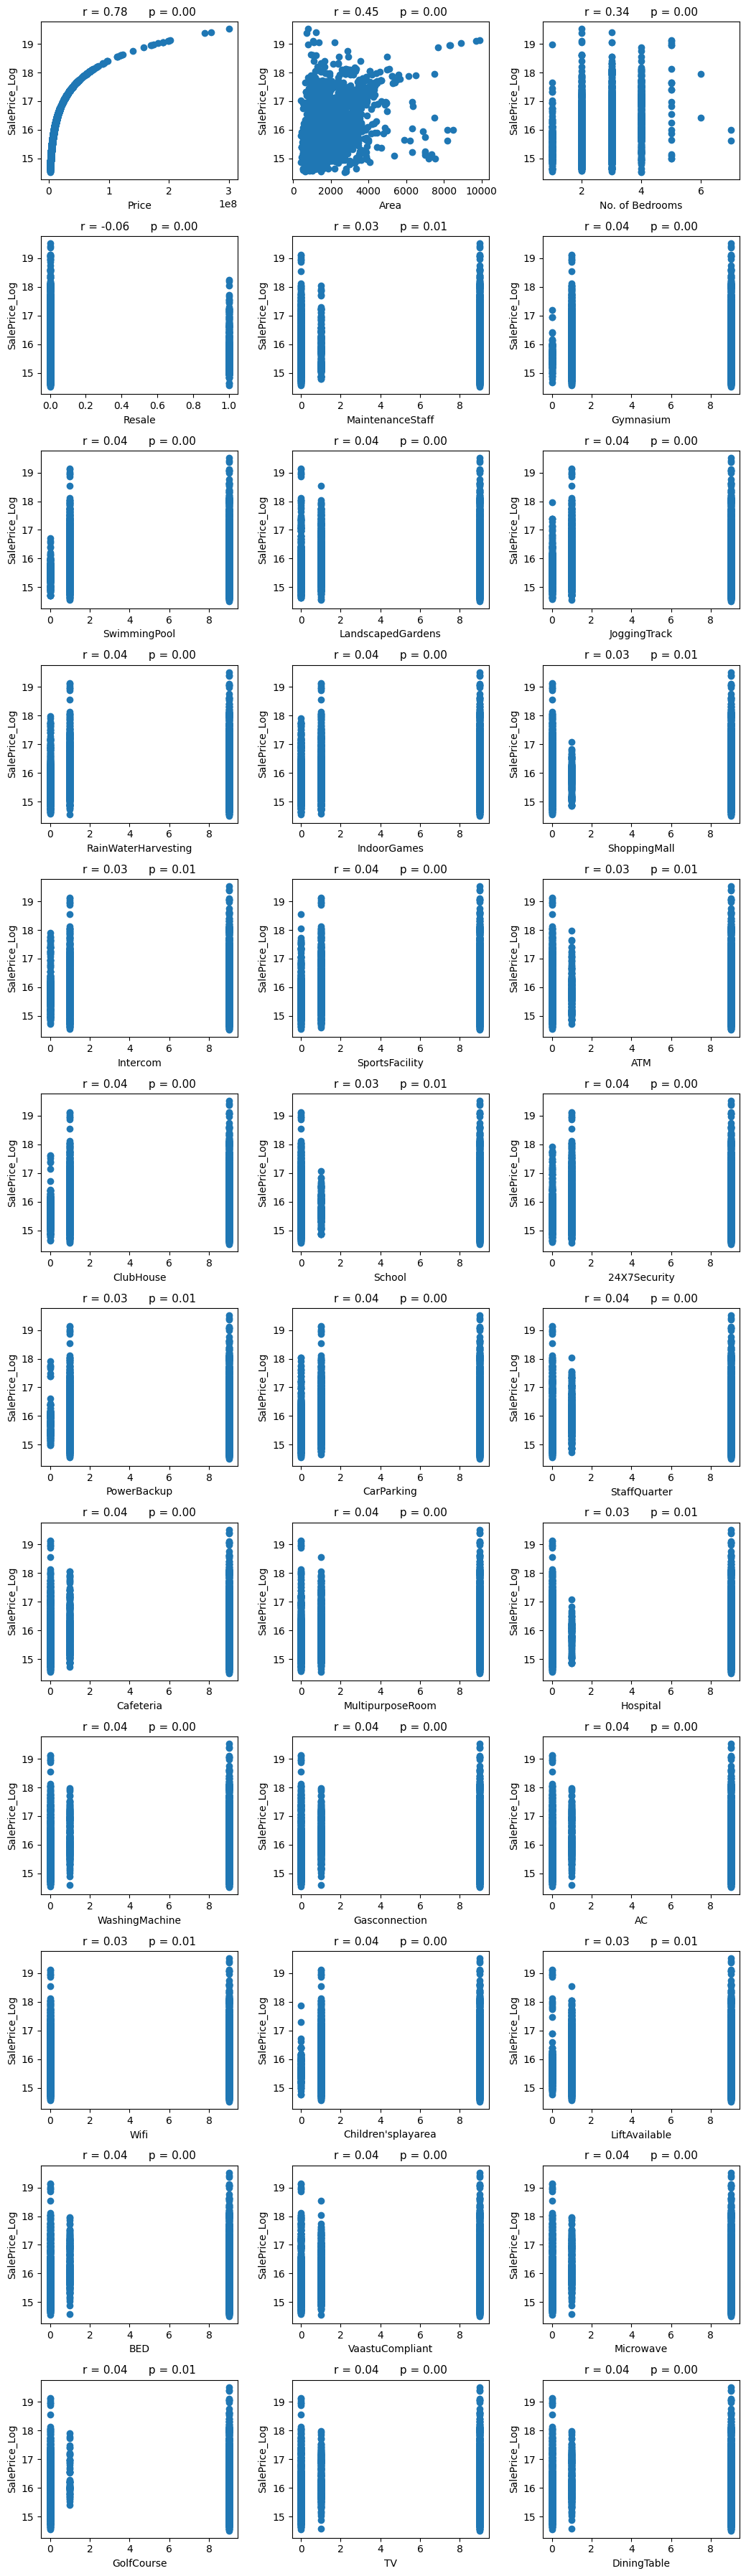

List of numerical features and their correlation coefficient to target:
SalePrice_Log          1.000000
Price                  0.776215
Area                   0.448697
No. of Bedrooms        0.344154
Resale                 0.059971
ClubHouse              0.042506
SportsFacility         0.042182
Gasconnection          0.042065
JoggingTrack           0.041550
SwimmingPool           0.040964
CarParking             0.040661
AC                     0.039871
BED                    0.039850
Stadium                0.039727
Sofa                   0.039727
WashingMachine         0.039727
TV                     0.039727
DiningTable            0.039727
Microwave              0.039727
IndoorGames            0.039125
RainWaterHarvesting    0.038934
24X7Security           0.038335
StaffQuarter           0.037578
LandscapedGardens      0.036890
Cafeteria              0.036675
Children'splayarea     0.036353
MultipurposeRoom       0.036203
Gymnasium              0.036100
VaastuCompliant        0.036089


In [5]:
nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0, nr_rows):
    for c in range(0, nr_cols):  
        i = r * nr_cols + c
        if i < len(li_plot_num_feats):
            axs[r][c].scatter(processed_data[li_plot_num_feats[i]], processed_data[target])
            stp = stats.pearsonr(processed_data[li_plot_num_feats[i]], processed_data[target])
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)
            axs[r][c].set_xlabel(li_plot_num_feats[i], fontsize=10)
            axs[r][c].set_ylabel(target, fontsize=10)

plt.tight_layout()    
plt.show()

# Calculate correlations only for numeric columns
corr = processed_data[numerical_feats].corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

# Threshold for minimum correlation value
min_val_corr = 0.038

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

# Print list of numerical features and their correlation coefficient to target
print("List of numerical features and their correlation coefficient to target:")
print(ser_corr)
print("*" * 30)
print("List of numerical features with correlation coefficient above", min_val_corr, ":")
print(cols_abv_corr_limit)
print("*" * 30)
print("List of numerical features with correlation coefficient below", min_val_corr, ":")
print(cols_bel_corr_limit)

#Check the distibution of locations : count how many times each value is met
for catg in list(categorical_feats) :
    print(processed_data[catg].value_counts())
    print('#'*50)

Now we neeed to handle our categorical data. We have only one column with Strings describing location. The simpliest way to deal with it - LabelEncoder(). Before that we additionaly clear our column by converting everything into Stings(even though we assume that everything is already in Sting) and filling Null-Values. We apply Label Encoding to the 'Location' column using fit_transform(), which assigns each unique location a unique integer value. The resulting 'Location_Encoded' column contains numeric analogues for each location, represented by integers.


Along the way we will identify list of features for price prediction. We alreay had all of them in our dataset. Next step is to handle missing values using .loc indexer. Using SimpleImputer i will replace missing values using a descriptive statistic ( most frequent) along each column.


In [6]:

label_encoder = LabelEncoder()

# Apply Label Encoding to the 'Location' column
processed_data['Location'] = processed_data['Location'].astype(str)
processed_data['Location'].fillna('unknown', inplace=True)
processed_data['Location_Encoded'] = label_encoder.fit_transform(processed_data['Location'])

features = ['Location_Encoded','Area', 'No. of Bedrooms', 'Resale', 'ClubHouse', 'SportsFacility', 
            'Gasconnection', 'JoggingTrack', 'SwimmingPool', 'CarParking', 'AC', 'BED', 'Stadium', 'Sofa', 'WashingMachine', 
            'TV', 'DiningTable', 'Microwave', 'IndoorGames', 'RainWaterHarvesting', '24X7Security']

X_train = processed_data[features]

columns_to_impute = ['Location_Encoded','Area', 'No. of Bedrooms', 'Resale', 'ClubHouse', 'SportsFacility', 
            'Gasconnection', 'JoggingTrack', 'SwimmingPool', 'CarParking', 'AC', 'BED', 'Stadium', 'Sofa', 'WashingMachine', 
            'TV', 'DiningTable', 'Microwave', 'IndoorGames', 'RainWaterHarvesting', '24X7Security']

for column in columns_to_impute:
   X_train.loc[X_train[column] == 9, column] = np.nan

imputer = SimpleImputer(strategy="most_frequent")
X_train_imputed = imputer.fit_transform(X_train)

C:\Users\Polya\AppData\Local\Temp\ipykernel_680\717800765.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  processed_data['Location'].fillna('unknown', inplace=True)


The most interesting part of the project is coming. We will train different regression models and evaluate their performance. 
Metrics for evaluation will be: 

Mean Squared Error
- A typical statistic for judging the quality of regression models is the Mean Squared Error (MSE). The average squared error between the target variable and its projected value is calculated. The better the model fits the data, the less the MSE score. 

Root Mean Squared Error
- It is the square root of the average squared difference; RMSE is similar but takes the square root of the average squared difference. The fact that it is stated in the same units as the objective variable makes it a popular measure.

The average absolute difference between the anticipated and actual values of the target variable is known as the Mean Absolute Error (MAE). When comparing estimation methods, MAE is preferred since it is less likely to be affected by extreme values.

So first we generalize prediction making and create function def train_evaluate_model(). Later on we collect models in the dictionary and plot the result to compare performance metrics visually. 

In [7]:
def train_evaluate_model(model, X_train, y_train):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_train)

    # Evaluate the model
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)

    return mae, mse, rmse

Linear Regression Model:
MAE: 0.41
MSE: 0.34
RMSE: 0.58
------------------------------
Ridge Regression Model:
MAE: 0.41
MSE: 0.34
RMSE: 0.58
------------------------------
Lasso Regression Model:
MAE: 0.43
MSE: 0.36
RMSE: 0.60
------------------------------
Decision Tree Model:
MAE: 0.13
MSE: 0.09
RMSE: 0.30
------------------------------
Random Forest Model:
MAE: 0.20
MSE: 0.11
RMSE: 0.33
------------------------------
Gradient Boosting Model:
MAE: 0.36
MSE: 0.27
RMSE: 0.52
------------------------------


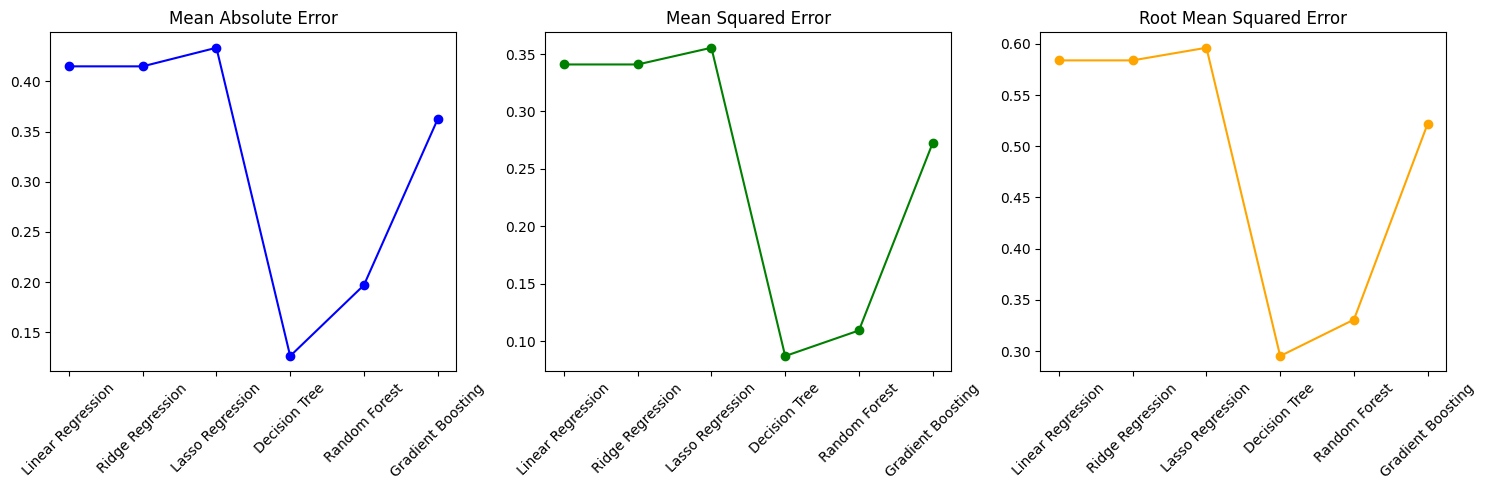

In [8]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}
mae_scores = []
mse_scores = []
rmse_scores = []
model_names = []

for model_name, model in models.items():
    mae, mse, rmse = train_evaluate_model(model, X_train_imputed, y_train)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    model_names.append(model_name)

    print(f"{model_name} Model:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print("-" * 30)

# Plotting


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(model_names, mae_scores, 'o-', color='blue')
plt.title('Mean Absolute Error')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.plot(model_names, mse_scores, 'o-', color='green')
plt.title('Mean Squared Error')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.plot(model_names, rmse_scores, 'o-', color='orange')
plt.title('Root Mean Squared Error')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




Visually we obviously see that Decision Tree and Random Forest had the best performance so far. So we stick on those two models to use in our future predictions of prices. 

In [9]:
def make_prediction(model_name, location, area, bedrooms, Resale, ClubHouse, SportsFacility, 
            Gasconnection, JoggingTrack, SwimmingPool, CarParking, AC, BED, Stadium, Sofa, WashingMachine, 
            TV, DiningTable, Microwave, IndoorGames, RainWaterHarvesting,dailySecurity ):


    model = models[model_name]
    
    data = {
        "Location_Encoded": location,
        "Area": area,
        "No. of Bedrooms": bedrooms,
        "Resale": Resale,
        "ClubHouse": ClubHouse,
        "SportsFacility":SportsFacility, 
        "Gasconnection":Gasconnection, 
        "JoggingTrack":JoggingTrack, 
        "SwimmingPool":SwimmingPool, 
        "CarParking":CarParking, 
        "AC":AC, 
        "BED":BED, 
        "Stadium":Stadium, 
        "Sofa":Sofa, 
        "WashingMachine":WashingMachine, 
        "TV":TV, 
        "DiningTable":DiningTable,
        "Microwave":Microwave, 
        "IndoorGames":IndoorGames, 
        "RainWaterHarvesting":RainWaterHarvesting, 
        "24X7Security" :dailySecurity
    }

    df = pd.DataFrame(data, index=[0])
    for column in df.columns:
        df[column] = df[column].replace(9, np.nan)
    df_imputed = imputer.transform(df)
    prediction = model.predict(df_imputed)[0]
    original_price = np.exp(prediction)
    
    return f"Predicted apartment price: ${original_price:.2f}"

In [10]:
new_data = pd.read_csv(r"C:\Users\Polya\OneDrive\Рабочий стол\BA tests\Bangalore.csv")
new_data['Location'].fillna('unknown', inplace=True)

# Convert non-string values to strings
new_data['Location'] = processed_data['Location'].astype(str)


# Apply Label Encoding to the 'Location' column
new_data['Location_Encoded'] = label_encoder.fit_transform(new_data['Location'])

new_data_subset = new_data.head(10)
predictions = []
predictions_with_randomF= [] 

for index, row in new_data_subset.iterrows():
    # Extract feature values from the row
    location = row["Location_Encoded"]
    area = row["Area"]
    bedrooms = row["No. of Bedrooms"]
    Resale = row["Resale"]
    SwimmingPool = row["SwimmingPool"]
    ClubHouse = row["ClubHouse"]
    SportsFacility= row["SportsFacility"]
    Gasconnection =row["Gasconnection"]
    JoggingTrack=row["JoggingTrack"]
    CarParking =row["CarParking"]
    AC=row["AC"]
    BED=row["BED"]
    Stadium=row["Stadium"]
    Sofa =row["Sofa"]
    WashingMachine=row["WashingMachine"]
    TV =row["TV"]
    DiningTable=row["DiningTable"]
    Microwave=row["Microwave"]
    IndoorGames=row["IndoorGames"]
    RainWaterHarvesting=row["RainWaterHarvesting"]
    dailySecurity=row["24X7Security"]
    
    
    # Make prediction
    prediction = make_prediction("Decision Tree",location, area, bedrooms, Resale, ClubHouse, SportsFacility, 
            Gasconnection, JoggingTrack, SwimmingPool, CarParking, AC, BED, Stadium, Sofa, WashingMachine, 
            TV, DiningTable, Microwave, IndoorGames, RainWaterHarvesting, dailySecurity)

    predictions.append(prediction)

    prediction_with_randomF = make_prediction("Random Forest",location, area, bedrooms, Resale, ClubHouse, SportsFacility, 
            Gasconnection, JoggingTrack, SwimmingPool, CarParking, AC, BED, Stadium, Sofa, WashingMachine, 
            TV, DiningTable, Microwave, IndoorGames, RainWaterHarvesting, dailySecurity)

    predictions_with_randomF.append(prediction_with_randomF)

# Add predictions to the subset DataFrame
new_data_subset["Predicted Price"] = predictions
new_data_subset["Predicted Price with Random Forest"] = predictions_with_randomF

# Print the subset DataFrame with predicted prices
print(new_data_subset)

      Price  Area                         Location  No. of Bedrooms  Resale  \
0  30000000  3340                 JP Nagar Phase 1                4       0   
1   7888000  1045       Dasarahalli on Tumkur Road                2       0   
2   4866000  1179  Kannur on Thanisandra Main Road                2       0   
3   8358000  1675                     Doddanekundi                3       0   
4   6845000  1670                          Kengeri                3       0   
5   6797000  1220                         Horamavu                2       0   
6  20000000  2502                      Thanisandra                4       0   
7   7105000  1438                 Ramamurthy Nagar                3       0   
8   8405000  1405    Whitefield Hope Farm Junction                3       0   
9   3506000   660          Electronic City Phase 1                1       0   

   MaintenanceStaff  Gymnasium  SwimmingPool  LandscapedGardens  JoggingTrack  \
0                 1          1             1     

C:\Users\Polya\AppData\Local\Temp\ipykernel_680\3936478574.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data['Location'].fillna('unknown', inplace=True)
C:\Users\Polya\AppData\Local\Temp\ipykernel_680\3936478574.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_sub